# Random Forests

The following notebook is a combination of guided exploration of the random forest model using our hr dataset.

Your job is to fill in the missing code-blocks and analyze the outputs that your code produces.

Credit to [fares-ds](https://github.com/fares-ds) for the notebook.

Modifications to instructions and code are indicated via a note from me: (*Note*: ...)

## Decision Trees

Decision Trees are an important type of algorithm for predictive modeling machine learning.

The classical decision tree algorithms have been around for decades and modern variations like random forest are among the most powerful techniques available.

Classification and Regression Trees or CART for short is a term introduced by Leo Breiman to refer to Decision Tree algorithms that can be used for classification or regression predictive modeling problems.

Classically, this algorithm is referred to as “decision trees”, but on some platforms like R they are referred to by the more modern term CART.

The CART algorithm provides a foundation for important algorithms like bagged decision trees, random forest and boosted decision trees.

**CART Model Representation**

The representation for the CART model is a binary tree.

This is your binary tree from algorithms and data structures, nothing too fancy. Each root node represents a single input variable (x) and a split point on that variable (assuming the variable is numeric).

The leaf nodes of the tree contain an output variable (y) which is used to make a prediction.

Given a new input, the tree is traversed by evaluating the specific input started at the root node of the tree.

## Pros 

* Simple to understand and to interpret. Trees can be visualised.  
* Requires little data preparation.  
* Able to handle both numerical and categorical data. 
* Possible to validate a model using statistical tests.  
* Performs well even if its assumptions are somewhat violated by the true model from which the data were generated.  

## Cons

* Overfitting. Mechanisms such as pruning (not currently supported), setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem.  
* Decision trees can be unstable. Mitigant: Use decision trees within an ensemble.  
* Cannot guarantee to return the globally optimal decision tree. Mitigant: Training multiple trees in an ensemble learner  
* Decision tree learners create biased trees if some classes dominate. Recommendation: Balance the dataset prior to fitting  

## Random Forest

Random Forest is one of the most popular and most powerful machine learning algorithms. It is a type of ensemble machine learning algorithm called Bootstrap Aggregation or bagging.

To improve performance of Decision trees, we can use many trees with a random sample of features chosen as the split.

## Decision Tree & Random Forest Implementation in python

We will use Decision Tree & Random Forest in predicting the attrition of your valuable employees.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [2]:
# upload 'hr' dataset
df = pd.read_csv("hr.csv")

In [3]:
# print out the first 5 rows of your dataframe
df.head()

Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...                         1            80                 0   
1  ...                         4            80                 1   
2  ...                         2            80                 0   
3  ...                         3            80                 0   
4  ...                         4            80                 1   

   TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  YearsAtCompany  \
0                  8                      0               1               6   
1                 10                      3               3              10   
2                  7                      3               3               0   
3                  8                      3               3               8   
4                  6                      3               3               2   

  YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
0                  4                        0                     5  
1                  7                        1                     7  
2                  0                        0                     0  
3                  7                        3                     0  
4                  2                        2                     2  

[5 rows x 35 columns]

## EDA

<Axes: xlabel='Attrition', ylabel='count'>

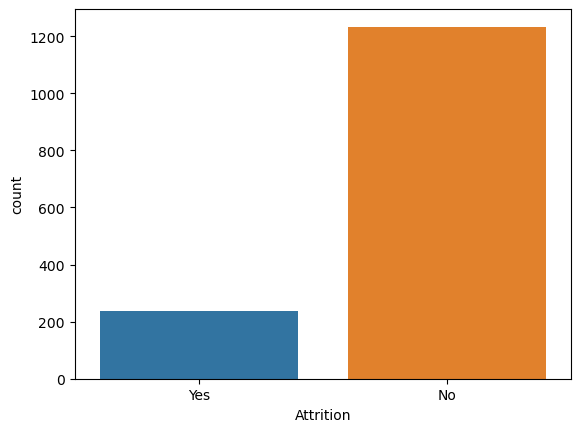

In [4]:
# create a countplot of the "Attrition" column in this dataframe to view if classes are balanced
sns.countplot(x='Attrition', data=df)

In [5]:
# drop the "EmployeeCount", 'EmployeeNumber', 'Over18', 'StandardHours' hours along the column axis 
df.drop(["EmployeeCount", "EmployeeNumber", "Over18", "StandardHours"], axis="columns", inplace=True)

In [6]:
# make a list of categorical columns where unique samples are less than 50
 
categorical_col = []
for column in df.columns:
    if df[column].dtype == object and len(df[column].unique()) <= 50:
        categorical_col.append(column)
        
df['Attrition'] = df.Attrition.astype("category").cat.codes

## Data Preprocessing

In [7]:
# remove the 'Attrition' column from the 'categorical_col' 
categorical_col.remove('Attrition')

In [8]:
# transform select categorical columns into dummies
label = LabelEncoder()
for column in categorical_col:
    df[column] = label.fit_transform(df[column])

In [11]:
# Create a 'X' and 'Y' training set, where 'X' is simply the dataframe without the 'Attrition' column
X = df.drop('Attrition', axis=1)

# and 'Y' is the 'Attrition' column
y = df['Attrition']

# create 'train_test_split' splits on the X and Y data where the test_size is 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
# create a `print_score` method to generate a report
 
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

## Decision Tree Classifier

Decision Tree parameters:

criterion: The function to measure the quality of a split. Supported criteria are "gini" for the Gini impurity and "entropy" for the information gain.  

splitter: The strategy used to choose the split at each node. Supported strategies are "best" to choose the best split and "random" to choose the best random split.  

max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.  

min_samples_split: The minimum number of samples required to split an internal node.  

min_samples_leaf: The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.  

min_weight_fraction_leaf: The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.  

max_features: The number of features to consider when looking for the best split.  

max_leaf_nodes: Grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.  

min_impurity_decrease: A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
min_impurity_split: Threshold for early stopping in tree growth. A node will split if its impurity is above the threshold, otherwise it is a leaf.  


In [13]:
# create a simple DecisionTreeClassifier object

tree_clf = DecisionTreeClassifier(random_state=42)

# fit on X_train & y_train data
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [14]:
# print the report of the DecisionTree performance
print_score(tree_clf, X_train, y_train, X_test, y_test, train=True)
print_score(tree_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    853.0  176.0       1.0     1029.0        1029.0
_______________________________________________
Confusion Matrix: 
 [[853   0]
 [  0 176]]

Test Result:
Accuracy Score: 77.78%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.887363   0.259740  0.777778    0.573551      0.800549
recall       0.850000   0.327869  0.777778    0.588934      0.777778
f1-score     0.868280   0.289855  0.777778    0.579067      0.788271
support    380.000000  61.000000  0.777778  441.000000    441.000000
_______________________________________________
Conf

In [17]:
# search for the best possible hyperparameters, using GridSearchCV
# NOTE: This might take some time

params = {
    "criterion":("gini", "entropy"), 
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 20))), 
    "min_samples_split":[2, 3, 4], 
    "min_samples_leaf":list(range(1, 20)), 
}

tree_clf = DecisionTreeClassifier(random_state=42)
# TODO: Implement `GridSearchCV` object
tree_cv = GridSearchCV(
    tree_clf, 
    params, 
    scoring="f1", 
    n_jobs=-1, 
    verbose=1, 
    cv=5
)

tree_cv.fit(X_train, y_train)
best_params = tree_cv.best_params_
print(f"Best paramters: {best_params})")

tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(X_train, y_train)
print_score(tree_clf, X_train, y_train, X_test, y_test, train=True)
print_score(tree_clf, X_train, y_train, X_test, y_test, train=False)

Fitting 5 folds for each of 4332 candidates, totalling 21660 fits
Best paramters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 19, 'min_samples_split': 2, 'splitter': 'best'})
Train Result:
Accuracy Score: 86.78%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.887568    0.692308  0.867833     0.789938      0.854170
recall       0.962485    0.409091  0.867833     0.685788      0.867833
f1-score     0.923510    0.514286  0.867833     0.718898      0.853516
support    853.000000  176.000000  0.867833  1029.000000   1029.000000
_______________________________________________
Confusion Matrix: 
 [[821  32]
 [104  72]]

Test Result:
Accuracy Score: 87.30%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.891304   0.592593  0.873016    0.741948      0.849986
recall  

## Random Forest

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

Random forest algorithm parameters:

n_estimators: The number of trees in the forest.  

criterion: The function to measure the quality of a split. Supported criteria are "gini" for the Gini impurity and "entropy" for the information gain.
max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.  
 
min_samples_split: The minimum number of samples required to split an internal node.  

min_samples_leaf: The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.  

min_weight_fraction_leaf: The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.  

max_features: The number of features to consider when looking for the best split.  

max_leaf_nodes: Grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.  

min_impurity_decrease: A node will be split if this split induces a decrease of the impurity greater than or equal to this value.  

min_impurity_split: Threshold for early stopping in tree growth. A node will split if its impurity is above the threshold, otherwise it is a leaf.  

bootstrap: Whether bootstrap samples are used when building trees. If False, the whole datset is used to build each tree.  

oob_score: Whether to use out-of-bag samples to estimate the generalization accuracy.  

In [18]:
# create a 'RandomForestClassifier' 

rf_clf = RandomForestClassifier(n_estimators=100)

# fit the randomforest object using the X_train & y_train data
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [19]:
# generate a report on the random forest model

print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    853.0  176.0       1.0     1029.0        1029.0
_______________________________________________
Confusion Matrix: 
 [[853   0]
 [  0 176]]

Test Result:
Accuracy Score: 86.39%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.872093   0.545455  0.863946    0.708774      0.826912
recall       0.986842   0.098361  0.863946    0.542601      0.863946
f1-score     0.925926   0.166667  0.863946    0.546296      0.820904
support    380.000000  61.000000  0.863946  441.000000    441.000000
_______________________________________________
Conf

## Random Forest hyperparameter tuning

In [21]:
# search for the best possible hyperparameters, using RandomSearchCV
# NOTE: This might take some time

n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {
    'n_estimators': n_estimators, 
    'max_features': max_features,
    'max_depth': max_depth, 
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf, 
    'bootstrap': bootstrap
}

rf_clf = RandomForestClassifier(random_state=42)
# TODO: Implement `RandomizedSearchCV` object
rf_cv = RandomizedSearchCV(
    estimator=rf_clf, 
    scoring='f1',
    param_distributions=random_grid, 
    n_iter=200, 
    cv=5, 
    verbose=1, 
    random_state=42,
    n_jobs=-1
)

rf_cv.fit(X_train, y_train)
rf_best_params = rf_cv.best_params_
print(f"Best paramters: {rf_best_params})")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


In [ ]:
rf_clf = RandomForestClassifier(**rf_best_params)
rf_clf.fit(X_train, y_train)

print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)

Summary

In this notebook we learned the following lessons:

* Decision tree and random forest algorithms and the parameters of each algorithm.  
* How to tune hyperparameters for both Decision tree and Random Forest.  
* Balance your dataset before training to prevent the tree from being biased toward the classes that are dominant.
    * By sampling an equal number of samples from each class
    * By normalizing the sum of the sample weights (sample_weight) for each class to the same value.